### 1.1 加载包

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import DataReader as dr
import TsTool as tst
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# varietyId='m'
# deliveryMonth='1705'
# df = dr.getFtrQuots( varietyId, deliveryMonth )

In [3]:
# df.head()
# df.to_csv('test_data.csv')

In [4]:
df = pd.read_csv('test_data.csv', index_col=0)

### 第一步：画价格图和对数价格图

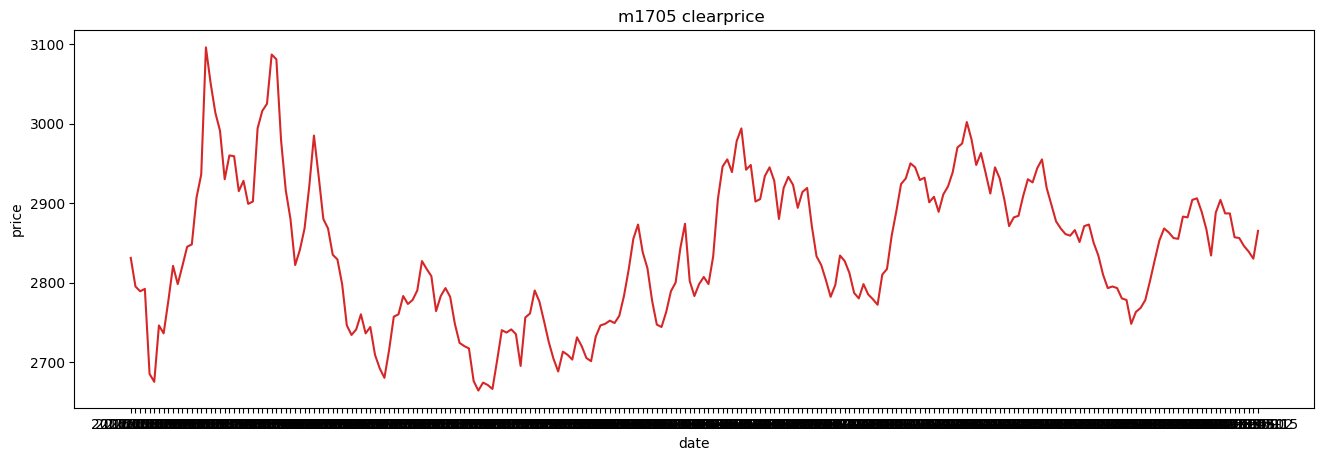

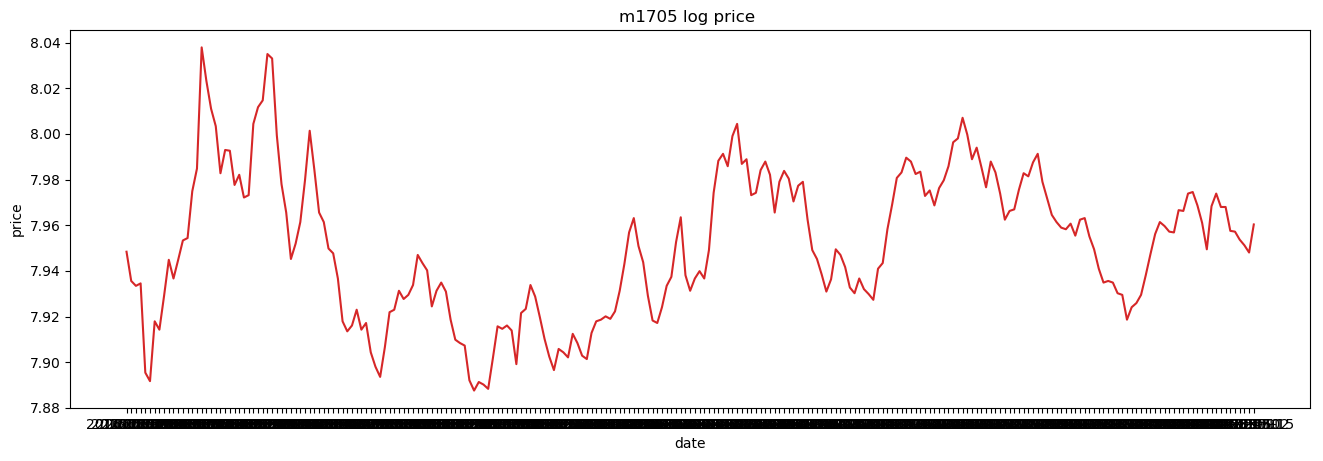

In [5]:
# #1. 价格画图 【画图，解释；做对数，再做对数差分，解释为什么】
tst.plot_df(df, x=df.index, y=df['CLEAR_PRICE'], title='m1705 clearprice ')
#
# # 对数价格画图
tst.plot_df(df, x=df.index, y=np.log(df['CLEAR_PRICE']), title='m1705 log price ')

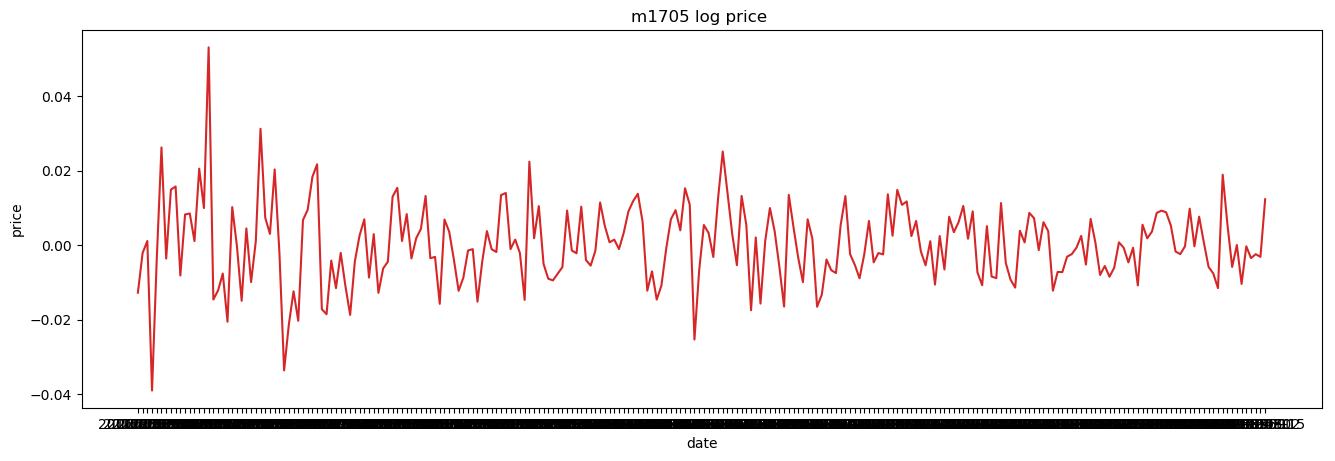

In [6]:
#2.对数差分的价格画图【】
df['LOG_PRICE']=np.log(df['CLEAR_PRICE'])
df['diff_log_price'] = df['LOG_PRICE'] - df['LOG_PRICE'].shift(1)    # x_diff = x - x.shift() #一阶差分
df = df.dropna()                                                     # 删除差分后的NaN值
tst.plot_df(df, x=df.index, y=df[['diff_log_price']], title='m1705 log price ')

In [7]:
#3.检验对数差分后数据的平稳性，【平稳性检验】
# 双重检验的结果表明数据是平稳的；
diff_log_price = df['diff_log_price']
tst.testStationarity( diff_log_price )

#【Dickey-Fuller test的原理：假设命题、拒绝域】
## H0:序列存在单位根，即序列是非平稳的；
## 以下结果中，P值为6.179036e-12，非常小，在1%的水平下仍然是显著的，所以拒绝H0，序列不存在单位根，即为平稳序列
    
#【kpss检验】
## H0：序列是平稳的，不存在单位根；
## 以下结果的p值为0.1表示，在1%的显著性水平仍然是显著的，所以可以不能拒绝原假设，即序列是平稳的

--------------------------Dickey-Fuller test-----------------------------------
Results of Dickey-Fuller Test:
Test Statistic                -7.643133e+00
p-value                        1.872826e-11
#Lags Used                     5.000000e+00
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64
--------------------------kpss test-----------------------------------
Test Statistic           0.028167
p-value                  0.100000
#Lags Used               2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


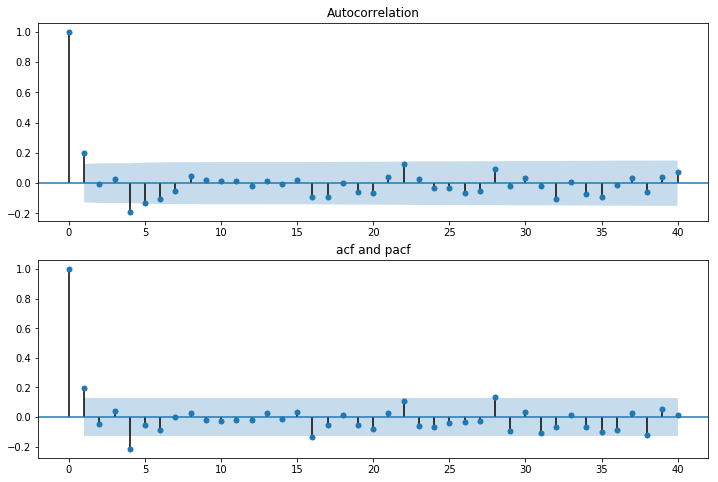

In [8]:
#4.画出ACF和PACF，尝试定出合理的阶数;【为什么画ACF\PACF图，定阶为什么选】
# ACF和PACF都迅速收敛，且都在4阶以内
tst.drawAcfPacf(diff_log_price)

# 自相关和偏自相关图呈现拖尾的趋势，所以先大致选定以下几个模型，然后通过比较这几个模型的AIC/BIC来选择最优的模型：
# ARIMA(1,1,1)
# ARIMA(1,1,4)
# ARIMA(4,1,4)

In [9]:
#5.AUTO_AMIMA,确定最优阶数，根据BIC来看最优的是(0,1,1)，为-1491.921
data = df['LOG_PRICE'] ;
model=auto_arima(data,trace=True,error_action='ignore',suppress_warnings=True);

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-1494.638, BIC=-1473.779, Fit time=1.392 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-1488.176, BIC=-1481.223, Fit time=0.065 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-1495.686, BIC=-1485.257, Fit time=0.161 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-1496.389, BIC=-1485.960, Fit time=0.242 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-1494.523, BIC=-1480.617, Fit time=0.774 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-1494.700, BIC=-1480.795, Fit time=0.290 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-1492.809, BIC=-1475.427, Fit time=0.963 seconds
Total fit time: 3.955 seconds


In [10]:
# 6.建立具体的ARIMA模型，并进行模型的残差分析【残差分析，并画图分析】
# 候选模型为(0,1,1),(1,1,1),(0,1,4), (1,1,4);
model_011 = ARIMA(data, order=(0,1,1));
result_011 = model_011.fit();
model_111 = ARIMA(data, order=(1,1,1));
result_111 = model_111.fit();
model_014 = ARIMA(data, order=(0,1,4));
result_014 = model_014.fit();
model_114 = ARIMA(data, order=(0,1,4));
result_114 = model_114.fit();

c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\kljdgf\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\base\

In [11]:
print("result_011:",result_011.aic, result_011.bic,sm.stats.durbin_watson(result_011.resid.values));
print("result_111:",result_111.aic, result_111.bic,sm.stats.durbin_watson(result_011.resid.values));
print("result_014:",result_014.aic, result_014.bic,sm.stats.durbin_watson(result_011.resid.values));
print("result_114:",result_114.aic, result_114.bic,sm.stats.durbin_watson(result_011.resid.values));

result_011: -1496.3892912880874 -1485.9599006322928 2.005669306710708
result_111: -1496.5384538675116 -1482.6325996597857 2.005669306710708
result_014: -1498.5473269366603 -1477.6885456250711 2.005669306710708
result_114: -1498.5473269366603 -1477.6885456250711 2.005669306710708


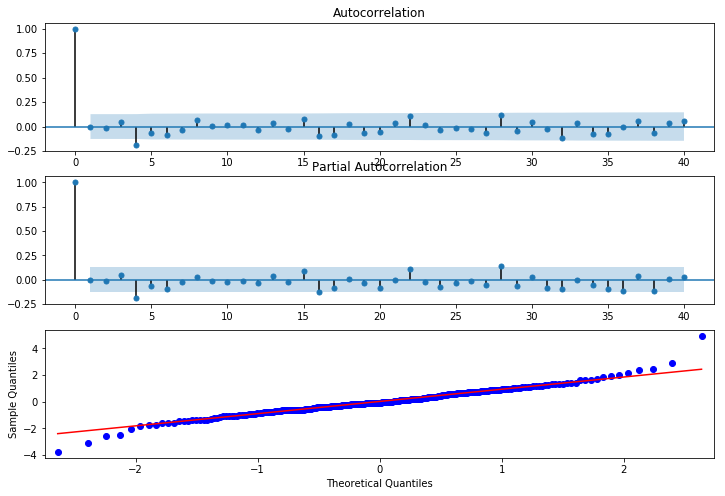

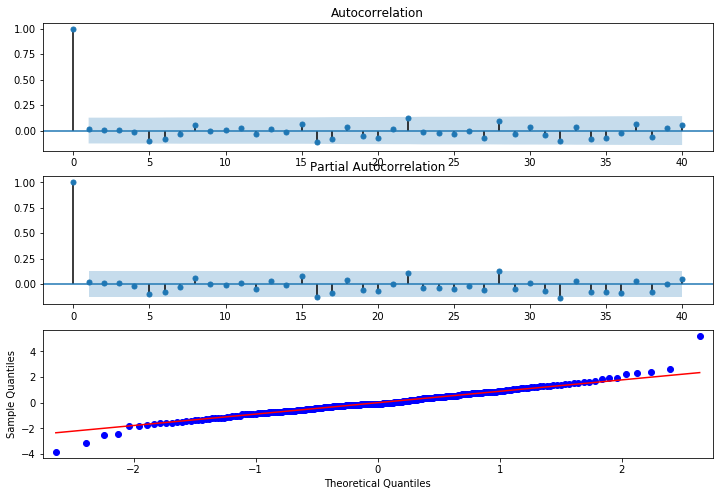

In [12]:
# 获得模型的残差，并画图分析    【进行残差检验】
# # result_011：4阶的残差相关性并没有得到消除
# # result_114：4阶的残差相关性被消除了
tst.tsdiag(result_011.resid);
tst.tsdiag(result_014.resid);

In [13]:
# 使用LB检验来确定残差是否是高斯白噪声    【LB为白噪声检验

# '''白噪声检验和预测不能同时进行，因为白噪声检验会把data数据集更改，进而无法在预测中使用'''


r,q,p = sm.tsa.acf(result_011.resid.values.squeeze(), qstat=True);
data1 = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data1, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))
#
r,q,p = sm.tsa.acf(result_014.resid.values.squeeze(), qstat=True)
data1 = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data1, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))


# 用LB进行白噪声检验：
## H0：序列为白噪声序列；
## 以下结果的P值均大于0.05，不能拒绝H0，即认为该序列为白噪声序列；

            AC          Q  Prob(>Q)
lag                                
1.0  -0.006082   0.008952  0.924620
2.0  -0.011846   0.043055  0.978702
3.0   0.051448   0.689055  0.875775
4.0  -0.188736   9.419926  0.051419
5.0  -0.061696  10.356855  0.065733
6.0  -0.084842  12.136274  0.058997
7.0  -0.038504  12.504359  0.085146
8.0   0.062452  13.476883  0.096461
9.0   0.004624  13.482238  0.141972
10.0  0.013979  13.531386  0.195459
11.0  0.018319  13.616161  0.254965
12.0 -0.031748  13.871921  0.308962
13.0  0.032267  14.137276  0.364248
14.0 -0.024741  14.293979  0.428047
15.0  0.072768  15.655579  0.405304
16.0 -0.093685  17.922569  0.328451
17.0 -0.083419  19.728036  0.288376
18.0  0.028950  19.946466  0.335842
19.0 -0.063308  20.995774  0.337034
20.0 -0.054978  21.790738  0.351973
21.0  0.032227  22.065144  0.395764
22.0  0.109739  25.261661  0.284726
23.0  0.012436  25.302903  0.334859
24.0 -0.036812  25.665942  0.370330
25.0 -0.019106  25.764192  0.420267
26.0 -0.028822  25.988828  0

Test MSE: 0.00005


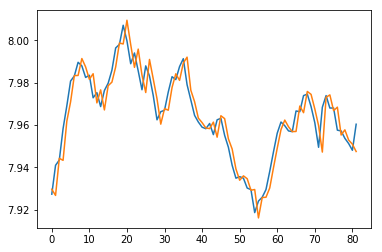

In [14]:
# 7. 做提前1步预测，并使用RMSE比较样本外的差异【预测，两个例子，做到位一个就行】
size = int(len(data) * 0.66)
train, test = data[0:size], data[size:len(data)]
history = [x for x in train]
predictions = list();
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test.iloc[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(list(test.values), predictions)
print('Test MSE: %.5f' % error)
# plot
plt.plot(test.values);
plt.plot(predictions)
plt.show()

第一步，模型的平稳性检验，先画时序图大致判断，在通过DF/KPSS检验来检验序列的平稳性，不平稳时用过差分来得到平稳的时间序列；
第二步，得到平稳的时间序列后，进行建模。通过ACF/PACF图给模型定阶，进而选择模型；
第三步，建立模型；
第四步，对残差序列进行白噪声检验，可以画ACF/PACF图，或者是通过LB检验对其进行白噪声检验；
第五步，利用建立的模型进行预测；